In [1]:
import xgboost

In [2]:
from xgboost import XGBClassifier

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

from time import sleep
from datetime import datetime as dt

sns.set(context='paper')

In [4]:
import json

In [5]:
import pandas as pd
import numpy as np

## Set in wider screen for more readability :

In [111]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load data

In [6]:
sourceFile = "data/EOS_ETH-5m.json"

In [7]:
with open(sourceFile) as f:
    data = json.load(f)

In [8]:
len(data)

40122

# Only take a part of the data

In [56]:
data_sample = data[-10000:]

In [57]:
len(data_sample)

10000

## transform to panda

In [58]:
cols = ['date', 'open', 'high', 'low', 'close', 'volume']

In [59]:
df = pd.DataFrame( data_sample, columns = cols)

# Create the indicators part :

In [60]:
import talib as tb

In [61]:
def technical(df):
    open = df['open'].values
    close = df['close'].values
    high = df['high'].values
    low = df['low'].values
    volume = df['volume'].values
    # define the technical analysis matrix
    retn = np.array([
        tb.MA(close, timeperiod=60),                                        # 1
        tb.MA(close, timeperiod=120),                                       # 2

        tb.ADX(high, low, close, timeperiod=14),                            # 3
        tb.ADXR(high, low, close, timeperiod=14),                           # 4

        tb.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)[0],    # 5
        tb.RSI(close, timeperiod=14),                                       # 6

        tb.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0],  # 7
        tb.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1],  # 8
        tb.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2],  # 9

        tb.AD(high, low, close, volume),                                    # 10
        tb.ATR(high, low, close, timeperiod=14),                            # 11

        tb.HT_DCPERIOD(close),                                              # 12

        tb.CDL2CROWS(open, high, low, close),                               # 13
        tb.CDL3BLACKCROWS(open, high, low, close),                          # 14
        tb.CDL3INSIDE(open, high, low, close),                              # 15
        tb.CDL3LINESTRIKE(open, high, low, close),                          # 16
        tb.CDL3OUTSIDE(open, high, low, close),                             # 17
        tb.CDL3STARSINSOUTH(open, high, low, close),                        # 18
        tb.CDL3WHITESOLDIERS(open, high, low, close),                       # 19
        tb.CDLABANDONEDBABY(open, high, low, close, penetration=0),         # 20
        tb.CDLADVANCEBLOCK(open, high, low, close),                         # 21
        tb.CDLBELTHOLD(open, high, low, close),                             # 22
        tb.CDLBREAKAWAY(open, high, low, close),                            # 23
        tb.CDLCLOSINGMARUBOZU(open, high, low, close),                      # 24
        tb.CDLCONCEALBABYSWALL(open, high, low, close),                     # 25
        tb.CDLCOUNTERATTACK(open, high, low, close),                        # 26
        tb.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0),        # 27
        tb.CDLDOJI(open, high, low, close),                                 # 28
        tb.CDLDOJISTAR(open, high, low, close),                             # 29
        tb.CDLDRAGONFLYDOJI(open, high, low, close),                        # 30
        tb.CDLENGULFING(open, high, low, close),                            # 31
        tb.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0),       # 32
        tb.CDLEVENINGSTAR(open, high, low, close, penetration=0),           # 33
        tb.CDLGAPSIDESIDEWHITE(open, high, low, close),                     # 34
        tb.CDLGRAVESTONEDOJI(open, high, low, close),                       # 35
        tb.CDLHAMMER(open, high, low, close),                               # 36
        tb.CDLHANGINGMAN(open, high, low, close),                           # 37
        tb.CDLHARAMI(open, high, low, close),                               # 38
        tb.CDLHARAMICROSS(open, high, low, close),                          # 39
        tb.CDLHIGHWAVE(open, high, low, close),                             # 40
        tb.CDLHIKKAKE(open, high, low, close),                              # 41
        tb.CDLHIKKAKEMOD(open, high, low, close),                           # 42
        tb.CDLHOMINGPIGEON(open, high, low, close),                         # 43
        tb.CDLIDENTICAL3CROWS(open, high, low, close),                      # 44
        tb.CDLINNECK(open, high, low, close),                               # 45
        tb.CDLINVERTEDHAMMER(open, high, low, close),                       # 46
        tb.CDLKICKING(open, high, low, close),                              # 47
        tb.CDLKICKINGBYLENGTH(open, high, low, close),                      # 48
        tb.CDLLADDERBOTTOM(open, high, low, close),                         # 49
        tb.CDLLONGLEGGEDDOJI(open, high, low, close),                       # 50
        tb.CDLLONGLINE(open, high, low, close),                             # 51
        tb.CDLMARUBOZU(open, high, low, close),                             # 52
        tb.CDLMATCHINGLOW(open, high, low, close),                          # 53
        tb.CDLMATHOLD(open, high, low, close, penetration=0),               # 54
        tb.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0),       # 55
        tb.CDLMORNINGSTAR(open, high, low, close, penetration=0),           # 56
        tb.CDLONNECK(open, high, low, close),                               # 57
        tb.CDLPIERCING(open, high, low, close),                             # 58
        tb.CDLRICKSHAWMAN(open, high, low, close),                          # 59
        tb.CDLRISEFALL3METHODS(open, high, low, close),                     # 60
        tb.CDLSEPARATINGLINES(open, high, low, close),                      # 61
        tb.CDLSHOOTINGSTAR(open, high, low, close),                         # 62
        tb.CDLSHORTLINE(open, high, low, close),                            # 63
        tb.CDLSPINNINGTOP(open, high, low, close),                          # 64
        tb.CDLSTALLEDPATTERN(open, high, low, close),                       # 65
        tb.CDLSTICKSANDWICH(open, high, low, close),                        # 66
        tb.CDLTAKURI(open, high, low, close),                               # 67
        tb.CDLTASUKIGAP(open, high, low, close),                            # 68
        tb.CDLTHRUSTING(open, high, low, close),                            # 69
        tb.CDLTRISTAR(open, high, low, close),                              # 70
        tb.CDLUNIQUE3RIVER(open, high, low, close),                         # 71
        tb.CDLUPSIDEGAP2CROWS(open, high, low, close),                      # 72
        tb.CDLXSIDEGAP3METHODS(open, high, low, close)                      # 73
    ]).T
    return retn

In [62]:
techData = technical(df)

In [114]:
def pdTechnical(df):
    open = df['open'].values
    close = df['close'].values
    high = df['high'].values
    low = df['low'].values
    volume = df['volume'].values
    # define the technical analysis matrix
    indicList = {
        'MA60'   :tb.MA(close, timeperiod=60),                                        # 1
        'MA120'  :tb.MA(close, timeperiod=120),                                       # 2

        'ADX'    :tb.ADX(high, low, close, timeperiod=14),                            # 3
        'ADXR'   :tb.ADXR(high, low, close, timeperiod=14),                            # 4
        'MACD'   :tb.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)[0],    # 5
        'RSI_14' :tb.RSI(close, timeperiod=14),                                       # 6
        'RSI_25' :tb.RSI(close, timeperiod=25),                                       # 6

        'BBANDS0':tb.BBANDS(close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[0],  # 7
        'BBANDS1':tb.BBANDS(close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[1],  # 8
        'BBANDS2':tb.BBANDS(close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[2],  # 9

        'AD'    :tb.AD(high, low, close, volume),                                    # 10
        'ATR'   :tb.ATR(high, low, close, timeperiod=14),                            # 11

        'HT_DCPERIOD':tb.HT_DCPERIOD(close),                                              # 12
        
        'ROC'   :tb.ROC(close, timeperiod=10),

        'STDDEV':tb.STDDEV(close, timeperiod=5, nbdev=1),
        'OBV'   :tb.OBV(close, volume),
        'TSF'   :tb.TSF(close, timeperiod=14),
        'MFI'   :tb.MFI(high, low, close, volume, timeperiod=14),
        'WILLR' :tb.WILLR(high, low, close, timeperiod=14)
    }

    df2 = pd.DataFrame(indicList)
    return df2

In [115]:
df3 = pdTechnical(df)

## Create the labels 
When the max of the price on N candles is more than X % the current (close) price

In [89]:
def Label(df):
    nbCandles = 10
    increasePercent = .5 / 100.0 #  = 0.5%
    increaseFactor = increasePercent + 1
    df2 = df.copy()
    #df2["max"] = df2["close"].rolling( nbCandles ).max().shift( -(nbCandles-1) )
    maxFront = df2["close"].rolling( nbCandles ).max().shift( -(nbCandles-1) )
    df2["label"] = (maxFront > increaseFactor * df2['close']).astype(int)
    return df2
    

In [90]:
df2 = Label(df)


## Set up xgboost, copy from :
https://github.com/allenfrostline/Chinese-A-Share-Price-Prediction/blob/master/xgb.py

In [91]:
class classifier:
    def __init__(self):
        self.model = XGBClassifier()
        self.progress = 0

    def para_tuning(self, X, y, para, grid, seed=0, verbose=False):  # verbose = 1 for tuning log, verbose = 2 for plotting, verbose = 3 for both

        # determine which to parameter to tune this time
        if para == '':
            return None
        elif para == 'learning_rate':
            param_grid = dict(learning_rate=grid)  # [0,0.1]
        elif para == 'max_depth':
            param_grid = dict(max_depth=grid)  # int
        elif para == 'min_child_weight':
            param_grid = dict(min_child_weight=grid)  # [0,1]
        elif para == 'gamma':
            param_grid = dict(gamma=grid)  # [0,1]
        elif para == 'max_delta_step':
            param_grid = dict(max_delta_step=grid)  # int
        elif para == 'colsample_bytree':
            param_grid = dict(colsample_bytree=grid)  # [0,1]
        elif para == 'reg_alpha':
            param_grid = dict(reg_alpha=grid)  # [0,1]
        elif para == 'reg_lambda':
            param_grid = dict(reg_lambda=grid)  # [0,1]
        else:
            print('WRONG PARAMETER.')
            return None
        kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=seed)
        grid_search = GridSearchCV(self.model, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold)
        grid_result = grid_search.fit(X, y)
        # summarize results
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        if verbose == 1 or verbose == 3:
            for mean, stdev, param in zip(means, stds, params):
                print('{:.4f} ({:.4f}) WITH: {} = {}'.format(mean, stdev, para, list(param.values())[0]))
            print('-' * 63)
        self.progress += 1
        progress = int(self.progress / 7 * 100)
        progress_bar = int(self.progress / 7 * 58)
        print('\r' + '█' * progress_bar + ' ' * (58 - progress_bar) + ' {:>3}%'.format(progress), end='')
        if verbose == 2 or verbose == 3:
            # plot
            plt.close()
            plt.figure(figsize=(20, 10))
            plt.errorbar(grid, means, yerr=stds)
            plt.title('XGBoost {} Tuning'.format(para))
            plt.xlabel(para)
            plt.ylabel('accuracy')
            plt.show()
        return list(grid_result.best_params_.values())[0]

    def tune(self, X, y, verbose=False, seed=0):
        self.model.seed = seed
        # fit model no training data
        print('-' * 63)
        print('AUTO TUNING ON TRAINING DATASET.')
        self.model.n_estimators = 1024
        self.model.subsample = 0.6
        self.model.learning_rate = 0.01

        self.model.max_depth = self.para_tuning(X, y, 'max_depth', [2, 4, 6, 8], seed, verbose)
        self.model.min_child_weight = self.para_tuning(X, y, 'min_child_weight', [4, 8, 12, 16], seed, verbose)
        self.model.gamma = self.para_tuning(X, y, 'gamma', [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8], seed, verbose)
        self.model.max_delta_step = self.para_tuning(X, y, 'max_delta_step', [0, 1, 2, 4], seed, verbose)
        self.model.colsample_bytree = self.para_tuning(X, y, 'colsample_bytree', [0.5, 0.6, 0.7], seed, verbose)
        self.model.reg_alpha = self.para_tuning(X, y, 'reg_alpha', [0, 0.001, 0.01, 0.1, 10, 100], seed, verbose)
        self.model.reg_lambda = self.para_tuning(X, y, 'reg_lambda', [0, 0.001, 0.01, 0.1, 10, 100], seed, verbose)
        self.model.learning_rate /= 2

        sleep(3)
        print('\rAUTO TUNING FINISHED.' + ' ' * 42)
        print('-' * 63)
        automodelReviewing = True
        if automodelReviewing or input('MODEL REVIEWING? (Y/N) ') == 'Y':
            print(self.model)

    def train(self, data, early_stopping_rounds=None, verbose=True, seed=0):
        X_train, y_train = data.train[0], data.train[1]
        X_test, y_test = data.test[0], data.test[1]

        # tune paramters using trainging dataset
        self.tune(X_train, y_train, seed=seed)
        print('-' * 63)
        # train the model with optimized parameters
        print('MODEL TRAINING.')
        metric = ['error', 'logloss', 'auc']
#         self.model.min_child_weight = 4
        self.model.fit(X_train, y_train,
                       eval_metric=metric,
                       eval_set=[(X_train, y_train), (X_test, y_test)],
                       early_stopping_rounds=early_stopping_rounds,
                       verbose=False)

        # make predictions for train data
        y_pred = self.model.predict(X_train)
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        accuracy = accuracy_score(y_train, predictions)
        print('TRAINING FINISHED.')
        print('ACCURACY TRAINING: {:.2f}%'.format(accuracy * 100))

        # make predictions for test data
        y_pred = self.model.predict(X_test)
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        accuracy = accuracy_score(y_test, predictions)
        print('ACCURACY TESTING: {:.2f}%'.format(accuracy * 100))

        if verbose is True:
            try:
                # plot boosting results
                results = self.model.evals_result()
                epochs = len(results['validation_0'][metric[0]])
                x_axis = range(0, epochs)
                plt.style.use('ggplot')
                plt.rcParams['font.size'] = 8
                plt.figure(figsize=(20, 10))
                i = 0
                for m in metric:
                    ax = plt.subplot2grid((len(metric), 2), (i, 0))
                    i += 1
                    ax.plot(x_axis, results['validation_0'][m], label='Train')
                    ax.plot(x_axis, results['validation_1'][m], label='Test')
                    ax.legend()
                    ax.set_ylabel(m)
                # plot feature importances
                features = data.features
                mapFeat = dict(zip(['f' + str(i) for i in range(len(features))], features))
                imp = pd.Series(self.model.get_booster().get_fscore())
                imp.index = imp.reset_index()['index'].map(mapFeat)
                ax = plt.subplot2grid((len(metric), 2), (0, 1), rowspan=len(metric))
                imp.sort_values().plot(kind='barh')
                ax.set_ylabel('importance')
                plt.show()
            except:
                print ("Exception : " + str(traceback.format_exc()) )
                print('PLOTTING ERROR.')

## filling the data struct :

In [116]:
seq_length = 3
features = sum([[c + '[T-{}]'.format(i) for c in ['open', 'close', 'high', 'low', 'volume', 'turnover']] for i in range(seq_length)], []) + \
            list(df3)


In [117]:
df4 = df3.copy()
df4["label"] = df2["label"]
df4.dropna(inplace=True)
df4.reset_index(drop=True, inplace=True)

In [118]:
train_size = 0.8
train_len = int(len(df4) * train_size)

In [119]:
data_train, data_test = df4[:train_len], df4[train_len:]

split X and Y ( input and ouput ) :

In [120]:
y_test = data_test[["label"]]
y_train = data_train[["label"]]

In [121]:
x_test = data_test.copy()
x_test.drop( ["label"], inplace=True, axis=1)
x_train = data_train.copy()
x_train.drop( ["label"], inplace=True, axis=1)

In [122]:
 # print a brief table about the train and test dataset
print('┌────────┬────────┬────────┐')
print('│   %%   │   ++   │   --   │')
print('├────────┼────────┼────────┤')
print('│  TRAIN │ {:>5.2f}% │ {:>5.2f}% │'.format( y_train.sum()[0] / len(y_train) * 100, 100 - y_train.sum()[0] / len(y_train) * 100))
print('├────────┼────────┼────────┤')
print('│  TEST  │ {:>5.2f}% │ {:>5.2f}% │'.format(y_test.sum()[0] / len(y_test) * 100, 100 - y_test.sum()[0] / len(y_test) * 100))
print('└────────┴────────┴────────┘')


┌────────┬────────┬────────┐
│   %%   │   ++   │   --   │
├────────┼────────┼────────┤
│  TRAIN │ 42.66% │ 57.34% │
├────────┼────────┼────────┤
│  TEST  │ 32.07% │ 67.93% │
└────────┴────────┴────────┘


In [123]:
trainingData = lambda : None

In [124]:
trainingData.train = [x_train, y_train]
trainingData.test = [x_test, y_test]
trainingData.features = features

## Let's try the beast !

---------------------------------------------------------------
AUTO TUNING ON TRAINING DATASET.


D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


████████                                                    14%

D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


████████████████                                            28%

D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


████████████████████████                                    42%

D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


█████████████████████████████████                           57%

D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


█████████████████████████████████████████                   71%

D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


█████████████████████████████████████████████████           85%

D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUTO TUNING FINISHED.                                          
---------------------------------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.1, learning_rate=0.005,
       max_delta_step=2, max_depth=8, min_child_weight=4, missing=None,
       n_estimators=1024, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.1,
       reg_lambda=0.1, scale_pos_weight=1, seed=123, silent=True,
       subsample=0.6)
---------------------------------------------------------------
MODEL TRAINING.


D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\tools\Anaconda3\envs\tensorFlow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. R

TRAINING FINISHED.
ACCURACY TRAINING: 83.35%
ACCURACY TESTING: 68.54%


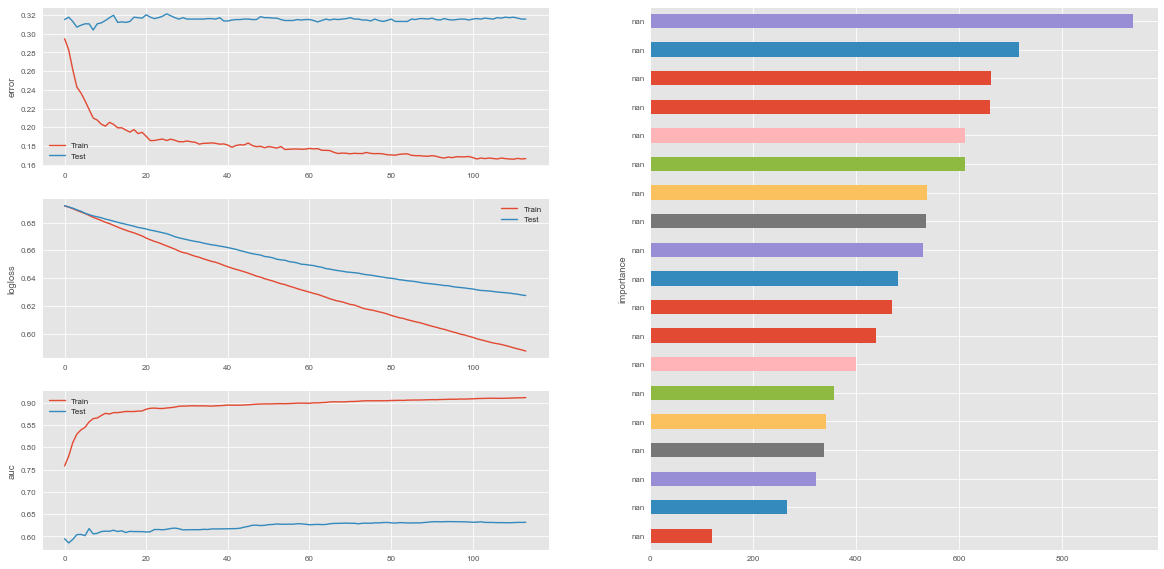

In [125]:
clf = classifier()
clf.train(trainingData, seed=123, early_stopping_rounds=20)
print('=' * 63)

In [126]:
clf.model.get_booster().get_fscore()

{'ATR': 717,
 'OBV': 663,
 'ROC': 481,
 'AD': 939,
 'ADX': 537,
 'RSI_25': 469,
 'BBANDS0': 337,
 'MA60': 531,
 'HT_DCPERIOD': 612,
 'BBANDS2': 341,
 'ADXR': 611,
 'TSF': 323,
 'STDDEV': 119,
 'WILLR': 439,
 'MA120': 661,
 'MACD': 535,
 'MFI': 358,
 'BBANDS1': 266,
 'RSI_14': 400}

In [127]:
clf.model.feature_importances_

array([0.05685833, 0.07077846, 0.0575008 , 0.06542456, 0.05728665,
       0.04283114, 0.05021951, 0.03608523, 0.02848271, 0.03651354,
       0.1005461 , 0.07677481, 0.06553164, 0.05150444, 0.01274226,
       0.07099261, 0.03458614, 0.03833387, 0.04700717], dtype=float32)

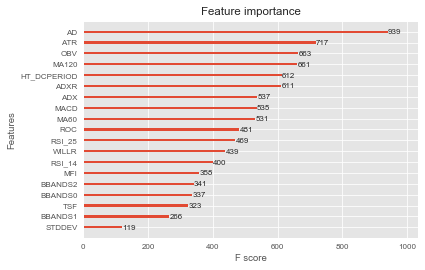

In [128]:
xgboost.plot_importance( clf.model)

In [109]:
import os
os.environ["PATH"] += os.pathsep + 'D:/tools/Anaconda3/pkgs/graphviz-2.38.0-4/Library/bin/'
os.environ["PATH"] += os.pathsep + 'D:/tools/Anaconda3/pkgs/graphviz-2.38.0-4/Library/bin/graphviz'

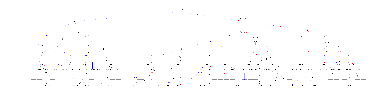

In [112]:
xgboost.plot_tree(clf.model)